# HW GA - Sinaya Nudel 203191663

In [1]:
%matplotlib inline 

import pandas as pd 
import numpy as np
import itertools
import copy 
import matplotlib.pyplot as plt

### Algorithm Settings 

#### Maze 

In [2]:
all_maze_size = [10, 25, 50]
obstacales = [0, 0.05, 0.1]

#### Algorithm 

In [3]:
generations_sizes = [25, 50, 100]

max_generations= 50
keep_from_previous = 0.25
mutate_rate_in_population = 0.25
mutate_rate_in_geneome = 0.4

all_trials = list() 

### Algorithm Logic 

#### Helping Functions

##### Move Functions 

In [4]:
move_left = lambda x,y: (x-1 , y)
move_right = lambda x,y: (x + 1, y)
move_up = lambda x,y: (x, y - 1) 
move_down = lambda x,y: (x, y + 1) 

def check_move(x, y, locations, maze, maze_size):
    for val in [x, y]:
        if val < 0 or val >= maze_size: 
            return 1
    if maze[x][y] == 1:
        return 2 
    
    #if len(locations) >= np.power(maze_size,2):
    #    return 3 
    if any([x == prev_x and y == prev_y for prev_x, prev_y in locations]):
        return 3 
    
    return 0 

moves_options = [move_up, move_down, move_left, move_right]

##### Maze Generation 

In [5]:
def generate_maze(maze_size, obstacales_count):
    maze = np.zeros([maze_size, maze_size])
    maze[0,0] = 2 
    maze[maze_size-1, maze_size-1] = 3 
    possible_indices = pd.DataFrame(np.transpose(np.where(maze==0)), columns=['x','y'])
    possible_indices = possible_indices.sample(obstacales_count)
    obs_location = zip(possible_indices['x'].values, possible_indices['y'].values)
    for curr_x, curr_y in obs_location:
        maze[curr_x, curr_y] = 1 
    return maze 

#generate_maze(5, 4)

##### Mutation Logic

In [6]:
def mutate(generation, mutate_rate_in_population, mutate_rate_in_geneome, size_to_keep):
    for sample_ind, sample in enumerate(generation): 
        if sample_ind >= size_to_keep:
            if np.random.rand() < mutate_rate_in_population:
                for item_ind in range(len(sample['moves_ind'])):
                    if np.random.rand() < mutate_rate_in_geneome:
                        new_move = np.random.choice([0,1,2,3], p=[0.35, 0.35, 0.15, 0.15])
                        new_action = [move_down, move_right, move_up, move_left][new_move]
                        sample['moves_ind'][item_ind] = new_move
                        sample['moves_actions'][item_ind] = new_action
    return generation 

##### Mixing Gene Function

In [7]:
def mix_perents(x, y, maze_size): 
    x_moves = x['moves_ind'].copy() 
    y_moves = y['moves_ind'].copy() 
    x_actions = x['moves_actions'].copy() 
    y_actions = y['moves_actions'].copy() 
    
    x_counter = x['counter']
    y_counter = y['counter']
    
    x_prob = y['score'] / float(x['score'] + y['score'])
    y_prob = x['score'] / float(x['score'] + y['score'])
    
    x_locations = x['locations'].copy() 
    y_locations = y['locations'].copy()
    
    child_actions = list() 
    child_moves = list() 
    if np.random.rand() < 0.66:
        if x_counter >= y_counter and x_counter > (maze_size / 2.0): 
            #print('X major')
            for _ in range(x_counter - 4): 
                child_actions.append(x_actions.pop(0))
                child_moves.append(x_moves[0])
                x_moves = x_moves[1:]
                curr_location = x_locations.pop(0)
                if any([(maze_size - x) < 4 for x in curr_location]):
                    break 

        elif y_counter > x_counter and y_counter > (maze_size / 2.0):
            #print('Y major')
            for _ in range(y_counter - 4): 
                child_actions.append(y_actions.pop(0))
                child_moves.append(y_moves[0])
                y_moves = y_moves[1:]
                curr_location = y_locations.pop(0)
                if any([(maze_size - x) < 4 for x in curr_location]):
                    break 

    #print('child action len - ' + str(len(child_actions)))
    for _ in range((maze_size * maze_size) - len(child_actions)): 
        is_x_superior_option = True if x_actions[0] in [move_down, move_right] else False 
        is_y_superior_option = True if y_actions[0] in [move_down, move_right] else False 
        probs = [0.5, 0.5]
        if is_x_superior_option == True and is_y_superior_option == False:
            probs = [0.9, 0.1]
        if is_x_superior_option == False and is_y_superior_option == True:
            probs = [0.1, 0.9]
            
        next_item = np.random.choice([0,1], p=probs)
        
        if next_item == 0: 
            #print('from x')
            child_actions.append(x_actions.pop(0))
            child_moves.append(x_moves[0])
            x_moves = x_moves[1:]
        else:
            #print('from y')
            child_actions.append(y_actions.pop(0))
            child_moves.append(y_moves[0])
            y_moves = y_moves[1:]
            
    child = {'moves_ind': child_moves,
             'moves_actions': child_actions, 
             'locations': None,
             'score':None,
             'counter':None, 
             'is_valid':None, 
             'fit_score': None}
    return child 

##### Generating Next Generation 

In [8]:
def generate_childrens(prev_gen=None, maze=None, gen_size=10, keep_prev_size=5, maze_size=None): 
    childrens = list() 
    if prev_gen is None:
        # generating random childerens 
        for curr_gen in range(gen_size):
            moves_ind = np.random.randint(0, 4, maze_size * maze_size)
            moves_actions = [moves_options[x] for x in moves_ind]
            child = {'moves_ind': moves_ind,
                     'moves_actions': moves_actions, 
                     'locations': None,
                     'counter': None, 
                     'is_valid':None, 
                     'score':None,
                     'fit_score': None}
            childrens.append(child)
    else:
        for keep_sample in prev_gen[:int(keep_prev_size / 2)]:
            childrens.append(copy.deepcopy(keep_sample))
        for _ in range(int(keep_prev_size / 2)):
            keep_sample = np.random.choice(prev_gen)
            childrens.append(copy.deepcopy(keep_sample))
        fit_scores = [x['fit_score'] for x in prev_gen]
        #print('fit scores')
        #print(fit_scores)
        for ind in range(gen_size - len(childrens)):
            
            curr_fit_scores = fit_scores[ind+1:]
            curr_fit_scores_sum = np.sum(curr_fit_scores)
            curr_fit_scores = [x / curr_fit_scores_sum for x in curr_fit_scores]
            if ind == 0 or np.random.rand() < 0.1:
                #second_sample_id = np.random.choice(range(len(prev_gen)), p=fit_scores)
                second_sample_id = np.random.choice(range(len(prev_gen)))
                childrens.append(mix_perents(prev_gen[ind], prev_gen[second_sample_id] , maze_size))
                #print('case 1: X id = ' + str(ind) + ' , Y id = ' + str(second_sample_id))
            else:
                curr_fit_scores_a = fit_scores[:ind]
                curr_fit_scores_sum_a = np.sum(curr_fit_scores_a)
                curr_fit_scores_a = [x / curr_fit_scores_sum_a for x in curr_fit_scores_a]
                first_sample_id = np.random.choice(range(ind), p=curr_fit_scores_a)
                second_sample_id = np.random.choice(range(len(prev_gen)), p=fit_scores)
                if prev_gen[first_sample_id]['score'] == prev_gen[second_sample_id]['score']:
                    #print('case 3: equal case')
                    childrens.append(mix_perents(np.random.choice(prev_gen), np.random.choice(prev_gen) , maze_size))
                else:
                    #print('case 2: X id = ' + str(first_sample_id) + ' , Y id = ' + str(second_sample_id))
                    childrens.append(mix_perents(prev_gen[first_sample_id], prev_gen[second_sample_id], maze_size))
    return childrens
    


##### Score Method for One Gene

In [9]:
def score_one_sample(sample, maze, maze_size):
    start_point = (0, 0)
    end_point = (maze_size - 1, maze_size - 1) 
    
    x, y = start_point 
    locations = [start_point]
    counter = 0 
    #print(sample['moves_ind'])
    for curr_action in sample['moves_actions']:
        x, y = curr_action(x, y)
        counter = counter + 1 
        #print('location - ' + str([x, y]))
        move_result = check_move(x, y, locations, maze, maze_size)
        if move_result == 0:
            locations.append((x, y))
            if x == end_point[0] and y == end_point[1]:
                sample['score'] = (counter / float(np.power(maze_size, 8)))
                sample['counter'] = counter 
                sample['locations'] = locations 
                sample['is_valid'] = True 
                #print('valid ' + str([x,y]) + ' score ' + str(sample['score']))
                return sample 
        else:
            x_dist =  np.abs(x - end_point[0])
            y_dist = np.abs(y - end_point[1])
            min_item = np.min([x_dist, y_dist, 2]) 
            max_item = np.max([x_dist, y_dist]) 
            #dist_penalty = np.power(max_item, 2) + min_item
            #dist_penalty = np.power(min_item, 2)/ float(counter * np.power(maze_size - max_item, 2)) 
            dist_penalty = np.power(np.max([(max_item-min_item), 10]),2) * np.max([(max_item-min_item), 5]) * np.max([min_item,1]) / (float(counter * np.power(np.max([maze_size - max_item,1]), 2))) 
            if min_item < 3 and (max_item - min_item) > 4:
                dist_penalty = dist_penalty * np.power((max_item), 2) 
            if min_item == 0 and max_item > 1:
                dist_penalty = dist_penalty * np.power(2, np.min([max_item, 5])) 
            #dist_penalty = dist_penalty * ((max_item - min_item + 1) / float(np.power(maze_size, 2)))
            sample['score'] = dist_penalty
            sample['counter'] = counter 
            sample['locations'] = locations 
            sample['is_valid'] = False 
            return sample 
            """
            if move_result == 1:
                #if min_item < 3:
                #    sample['score'] = sample['score'] * 5
                print('not_valid (out of bound) ' + str([x,y]) + ' counter ' + str(counter) + ' score = ' + str(sample['score']))
            if move_result == 2:
                #if min_item < 3:
                #    sample['score'] = sample['score'] * 5
                print('not_valid (block) ' + str([x,y]) + ' counter ' + str(counter) + ' score = ' + str(sample['score']))
            if move_result == 3:
                #if min_item < 3:
                #    sample['score'] = sample['score'] * 5
                print('not_valid (circle) ' + str([x,y]) + ' counter ' + str(counter) + ' score = ' + str(sample['score']))
            """
            
        


##### Fit Function Calculation

In [10]:
def score_generation(generation, maze, maze_size):
    scores = list() 

    for sample in generation:
        if sample is None: 
            print('here1')
        sample = score_one_sample(sample, maze, maze_size)
        if sample is None: 
            print('here2')
        scores.append(1 / float(sample['score']))
        
    scores_sum = np.sum(scores)
    scores = [x / scores_sum for x in scores]
   
    for sample, sample_fit_score in zip(generation, scores):
        sample['fit_score'] = sample_fit_score
    
    return sorted(generation, key=lambda d:d['fit_score'], reverse=True)

##### Test Converegence Method

In [11]:
def check_convergence(gen, counter, value): 
    if gen[0]['is_valid']:
        if gen[0]['score'] < value:
            return True, 0, gen[0]['score']
        else:
            return True, counter + 1, value
    else:
        return False, 0, gen[0]['score']

#### Run Logic (The Algorithm) Iterating Over All the Options we want to Test 

In [ ]:
# iterating over all combinations  
for maze_size, obstacles_fraction, gen_size in itertools.product(all_maze_size, obstacales, generations_sizes):
    print('Start Simulation ') 
    obstacales_count = int(obstacles_fraction * (maze_size * maze_size))
    keep_from_previous_count = int(keep_from_previous * gen_size)
    print('    maze size = ' + str(maze_size))
    print('    generation size = ' + str(gen_size))
    print('    obstacales count = ' + str(obstacales_count))
    
    
    # for analysis 
    curr_run = {'gen_size': gen_size, 
                'maze_size': maze_size, 
                'obstacle_count': obstacales_count, 
                'finish_gen': None, 
                'generations': list()}

    # start of actual algorithm 
    prev_gen = None 
    next_gen = None 
    maze = generate_maze(maze_size, obstacales_count)
    print('Maze of size ' + str([maze_size, maze_size]) + ' is:')
    print(maze) 
          
    all_generations = list() 
    counter = 0 
    best_value = maze_size
    for curr_gen in range(max_generations): 
        #print('Start Generation ' + str(curr_gen))
        next_gen = generate_childrens(prev_gen,maze, gen_size, keep_from_previous_count, maze_size)
        next_gen = score_generation(next_gen, maze, maze_size)
        next_gen = mutate(next_gen, mutate_rate_in_population, mutate_rate_in_geneome, keep_from_previous_count)
        next_gen = score_generation(next_gen, maze, maze_size)
        is_done, counter, best_value = check_convergence(next_gen, counter, best_value) 

        print('Generation - ' + str(curr_gen) +', best location - ' + str(next_gen[0]['locations'][-1]))
        all_generations.append(next_gen)
        if is_done and counter > 10:
            print('DONE!')
            break
        else: 
            prev_gen = next_gen
            
    all_trials.append({
        'generations':all_generations,
        'len': len(all_generations),
        'best': all_generations[-1][0],
        'valid': all_generations[-1][0]['is_valid'], 
        'gen_size': gen_size,
        'maze_size': maze_size,
        'obstacles': obstacales_count, 
        'maze': maze 
    })



### Results Analysis 

#### Visual Performance of Each Combination Tested 





















--------------------------------------------------
--------------------------------------------------
 Gen Size - 25
 Maze Size - [10 , 10]
 Obstacles Count - 0
 End Location - (9, 9)
 Was Solved - True


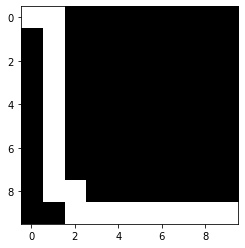





















--------------------------------------------------
--------------------------------------------------
 Gen Size - 50
 Maze Size - [10 , 10]
 Obstacles Count - 0
 End Location - (9, 9)
 Was Solved - True


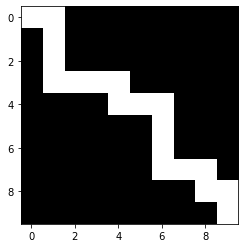





















--------------------------------------------------
--------------------------------------------------
 Gen Size - 100
 Maze Size - [10 , 10]
 Obstacles Count - 0
 End Location - (9, 9)
 Was Solved - True


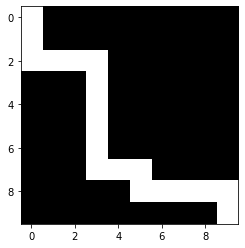





















--------------------------------------------------
--------------------------------------------------
 Gen Size - 25
 Maze Size - [10 , 10]
 Obstacles Count - 5
 End Location - (9, 9)
 Was Solved - True


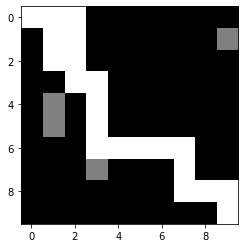





















--------------------------------------------------
--------------------------------------------------
 Gen Size - 50
 Maze Size - [10 , 10]
 Obstacles Count - 5
 End Location - (9, 9)
 Was Solved - True


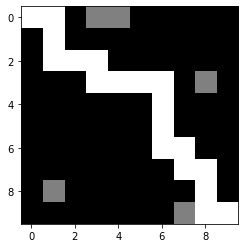





















--------------------------------------------------
--------------------------------------------------
 Gen Size - 100
 Maze Size - [10 , 10]
 Obstacles Count - 5
 End Location - (9, 9)
 Was Solved - True


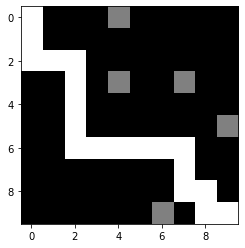





















--------------------------------------------------
--------------------------------------------------
 Gen Size - 25
 Maze Size - [10 , 10]
 Obstacles Count - 10
 End Location - (9, 9)
 Was Solved - True


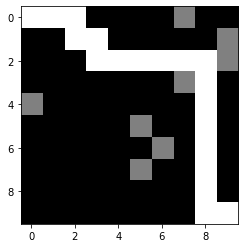





















--------------------------------------------------
--------------------------------------------------
 Gen Size - 50
 Maze Size - [10 , 10]
 Obstacles Count - 10
 End Location - (9, 9)
 Was Solved - True


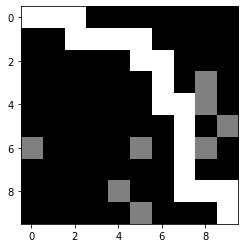





















--------------------------------------------------
--------------------------------------------------
 Gen Size - 100
 Maze Size - [10 , 10]
 Obstacles Count - 10
 End Location - (9, 9)
 Was Solved - True


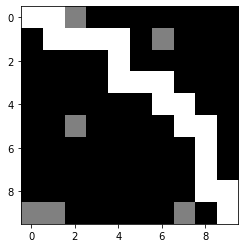





















--------------------------------------------------
--------------------------------------------------
 Gen Size - 25
 Maze Size - [25 , 25]
 Obstacles Count - 0
 End Location - (24, 24)
 Was Solved - True


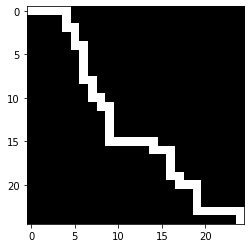





















--------------------------------------------------
--------------------------------------------------
 Gen Size - 50
 Maze Size - [25 , 25]
 Obstacles Count - 0
 End Location - (24, 24)
 Was Solved - True


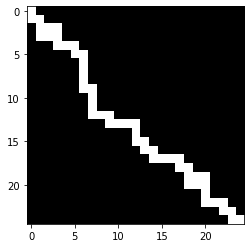





















--------------------------------------------------
--------------------------------------------------
 Gen Size - 100
 Maze Size - [25 , 25]
 Obstacles Count - 0
 End Location - (24, 24)
 Was Solved - True


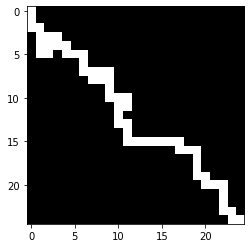





















--------------------------------------------------
--------------------------------------------------
 Gen Size - 25
 Maze Size - [25 , 25]
 Obstacles Count - 31
 End Location - (23, 24)
 Was Solved - False


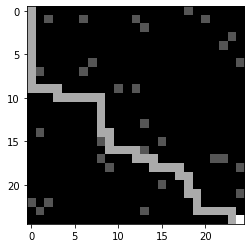





















--------------------------------------------------
--------------------------------------------------
 Gen Size - 50
 Maze Size - [25 , 25]
 Obstacles Count - 31
 End Location - (24, 24)
 Was Solved - True


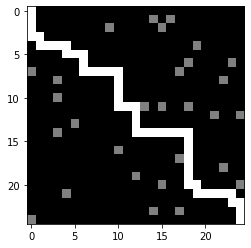





















--------------------------------------------------
--------------------------------------------------
 Gen Size - 100
 Maze Size - [25 , 25]
 Obstacles Count - 31
 End Location - (24, 24)
 Was Solved - True


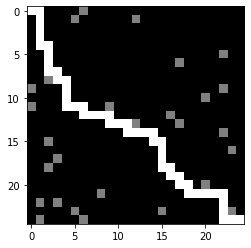





















--------------------------------------------------
--------------------------------------------------
 Gen Size - 25
 Maze Size - [25 , 25]
 Obstacles Count - 62
 End Location - (24, 15)
 Was Solved - False


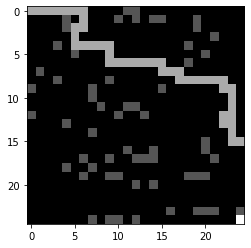





















--------------------------------------------------
--------------------------------------------------
 Gen Size - 50
 Maze Size - [25 , 25]
 Obstacles Count - 62
 End Location - (24, 24)
 Was Solved - True


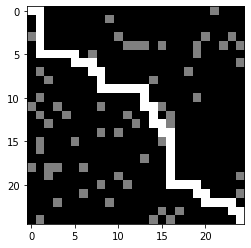





















--------------------------------------------------
--------------------------------------------------
 Gen Size - 100
 Maze Size - [25 , 25]
 Obstacles Count - 62
 End Location - (24, 24)
 Was Solved - True


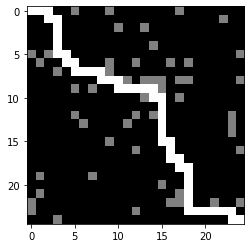





















--------------------------------------------------
--------------------------------------------------
 Gen Size - 25
 Maze Size - [50 , 50]
 Obstacles Count - 0
 End Location - (49, 31)
 Was Solved - False


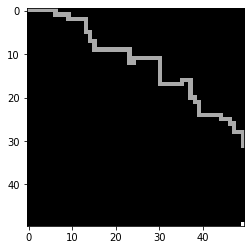





















--------------------------------------------------
--------------------------------------------------
 Gen Size - 50
 Maze Size - [50 , 50]
 Obstacles Count - 0
 End Location - (49, 49)
 Was Solved - True


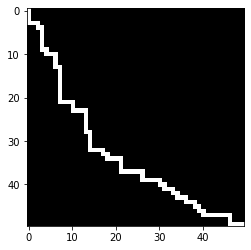





















--------------------------------------------------
--------------------------------------------------
 Gen Size - 100
 Maze Size - [50 , 50]
 Obstacles Count - 0
 End Location - (49, 49)
 Was Solved - True


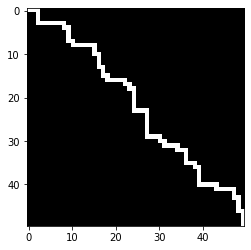





















--------------------------------------------------
--------------------------------------------------
 Gen Size - 25
 Maze Size - [50 , 50]
 Obstacles Count - 125
 End Location - (49, 48)
 Was Solved - False


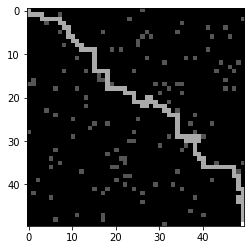





















--------------------------------------------------
--------------------------------------------------
 Gen Size - 50
 Maze Size - [50 , 50]
 Obstacles Count - 125
 End Location - (43, 49)
 Was Solved - False


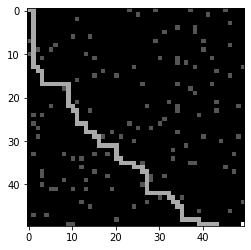





















--------------------------------------------------
--------------------------------------------------
 Gen Size - 100
 Maze Size - [50 , 50]
 Obstacles Count - 125
 End Location - (49, 49)
 Was Solved - True


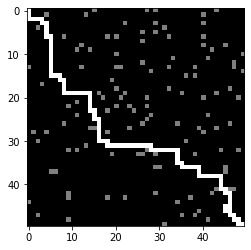





















--------------------------------------------------
--------------------------------------------------
 Gen Size - 25
 Maze Size - [50 , 50]
 Obstacles Count - 250
 End Location - (49, 20)
 Was Solved - False


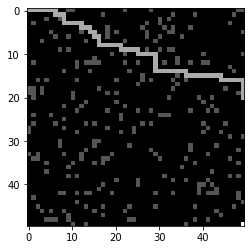





















--------------------------------------------------
--------------------------------------------------
 Gen Size - 50
 Maze Size - [50 , 50]
 Obstacles Count - 250
 End Location - (49, 49)
 Was Solved - True


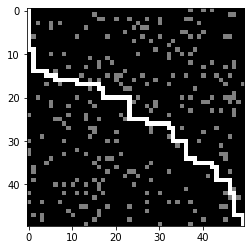





















--------------------------------------------------
--------------------------------------------------
 Gen Size - 100
 Maze Size - [50 , 50]
 Obstacles Count - 250
 End Location - (47, 49)
 Was Solved - False


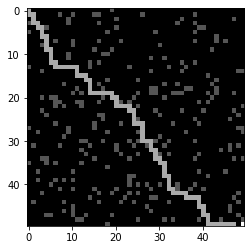

In [71]:
for curr_trial in all_trials:
    print('\n' * 20 + '-' * 50 + '\n' + '-' * 50)
    print(' Gen Size - ' + str(curr_trial['gen_size']))
    print(' Maze Size - [' + str(curr_trial['maze_size']) + ' , ' + str(curr_trial['maze_size']) + ']')
    print(' Obstacles Count - ' + str(curr_trial['obstacles']))
    print(' End Location - ' + str(curr_trial['best']['locations'][-1]))
    print(' Was Solved - ' + str(curr_trial['valid']))
    curr_maze = curr_trial['maze'].copy() 
    for x,y in curr_trial['best']['locations']:
        curr_maze[y][x] = 2
    plt.figure()
    _ = plt.imshow(curr_maze, cmap='gray')
    plt.show() 

In [50]:
results_list = list() 
for trial in all_trials:
    tmp = dict() 
    tmp['count'] = trial['len']
    tmp['gen_size'] = trial['gen_size']
    tmp['maze_size'] = trial['maze_size']
    tmp['solved_value'] = 1 if trial['valid'] is True else 0
    tmp['solved'] = trial['valid'] 
    final_x, final_y = trial['best']['locations'][-1]
    tmp['final_dist'] = (trial['maze_size'] - final_x -1) + (trial['maze_size'] - final_y - 1)
    tmp['obstacles'] = trial['obstacles']
    results_list.append(tmp)
    
results = pd.DataFrame(results_list)

#### Finish Sucessfully Maze Plots

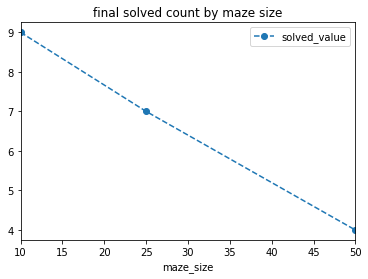

In [51]:
_ = results[['maze_size','solved_value']].groupby('maze_size').sum().plot(style='o--', title='final solved count by maze size')

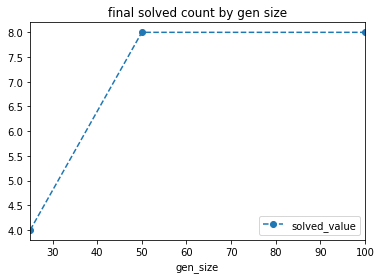

In [52]:
_ = results[['gen_size','solved_value']].groupby('gen_size').sum().plot(style='o--', title='final solved count by gen size')

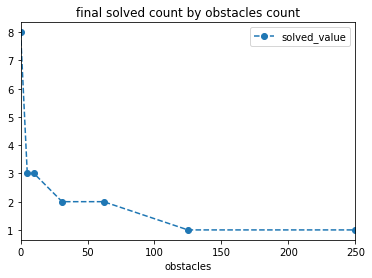

In [53]:
_ = results[['obstacles','solved_value']].groupby('obstacles').sum().plot(style='o--', title='final solved count by obstacles count')

#### Generation Count (Max Generation == 50)  Plots

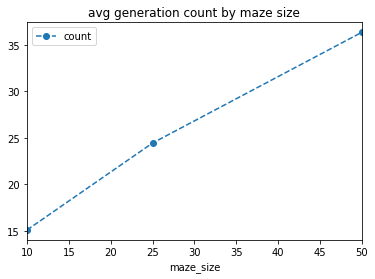

In [67]:
_ = results[['count','maze_size']].groupby('maze_size').mean().plot(style='o--', title='avg generation count by maze size')

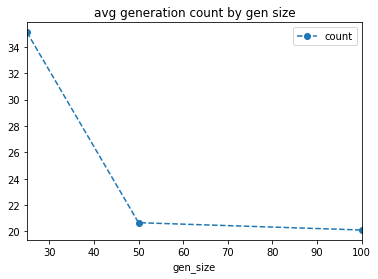

In [68]:
_ = results[['count','gen_size']].groupby('gen_size').mean().plot(style='o--', title='avg generation count by gen size')

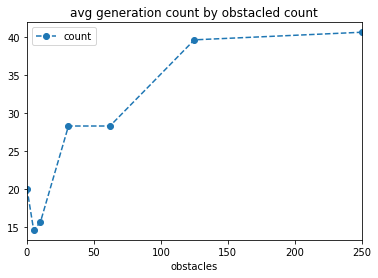

In [69]:
_ = results[['count','obstacles']].groupby('obstacles').mean().plot(style='o--', title='avg generation count by obstacled count')

0 is higher and its ok since there are more 0 games than other options 

#### Distance From Finish Points Plots

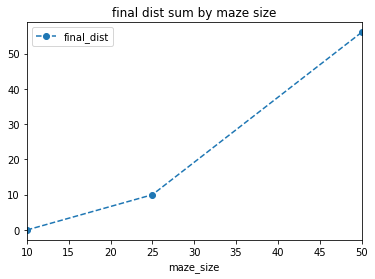

In [57]:
_ = results[['maze_size','final_dist']].groupby('maze_size').sum().plot(style='o--', title='final dist sum by maze size')

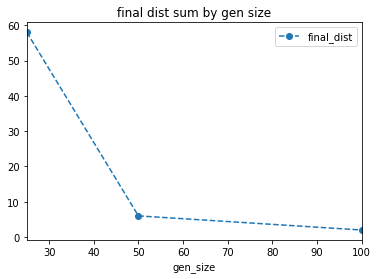

In [59]:
_ = results[['gen_size','final_dist']].groupby('gen_size').sum().plot(style='o--', title='final dist sum by gen size')

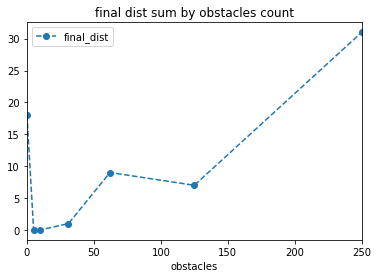

In [60]:
_ = results[['obstacles','final_dist']].groupby('obstacles').sum().plot(style='o--', title='final dist sum by obstacles count')

0 is higher and its ok since there are more 0 games than other options 

#### All Results Printed 

In [55]:
results

,count,gen_size,maze_size,solved_value,solved,final_dist,obstacles
0,16,25,10,1,True,0,0
1,15,50,10,1,True,0,0
2,14,100,10,1,True,0,0
3,16,25,10,1,True,0,5
4,15,50,10,1,True,0,5
5,13,100,10,1,True,0,5
6,17,25,10,1,True,0,10
7,15,50,10,1,True,0,10
8,15,100,10,1,True,0,10
9,17,25,25,1,True,0,0
